## **Contents:**

####1. Cleaning/NaN imputation

####2. Check dataset imbalance. Multicollinearity. Ideas to for dealing with class imbalance.


#### 3. Baseline model:

- I won't be dealing assumptions for logistic regression, but will at least plot multicollinearity heatmap;
- Fitting Logistic regression with default values;
- No data transformations;
- No cross-validation;
- f1/roc-auc and confusion matrix.

#### 4. Improving baseline model with data transformation and SMOTEEN:
- Dealing with imbalance via weight tuning for LogReg;
- Scaling numerical values (it can help convergence);
- Transformation of categoricals to Weight of evidence (often used for LogReg);
- Using SMOTEEN;
- Checking on holdout set.

#### 5. XGBoost.

#### 6.Ensembles.

#### 7.Possible improvements for future.

In [0]:
#@title
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive
from google.colab import drive
drive.mount('/content/drive')


In [0]:
#@title
!pip install scikit-plot
!pip install category_encoders
!pip install vecstack

In [0]:
import os
os.chdir('drive/My Drive/test_task')

**1. Importing / Cleaning data**

In [0]:
import warnings
warnings.filterwarnings("ignore")
from google.colab import files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import roc_auc_score,auc
from imblearn.combine import SMOTEENN 
from xgboost import XGBClassifier
from imblearn.metrics import sensitivity_score
from sklearn.metrics import balanced_accuracy_score

from scikitplot.metrics import plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score,average_precision_score
from sklearn import metrics
#from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import plot_precision_recall_curve

from sklearn.model_selection import cross_validate
import category_encoders

from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.base import TransformerMixin,BaseEstimator
from imblearn.pipeline import Pipeline as imb_Pipeline



In [0]:
df = pd.read_csv('train_df.csv',sep='\t')
df.drop('Unnamed: 0',axis=1,inplace=True)

Before building any baseline model we have to check whether we have raw categorical variables, encode them if such exist.

In [0]:
#Check whether there are any unencoded categories in our dataset
print(len(df.select_dtypes(include=['category','object']).columns.tolist()))

0


Let's delete those variable (columns) that consist of only one value and 'id':

In [0]:
#looping through columns to find features with only one value:
unit_features = []
for col in df.columns:
  #select features with one value(including NaN's)
  if df[col].nunique(dropna=False)==1:
    unit_features.append(col)
#delete such features
df.drop(unit_features,axis=1,inplace=True)
#delete id feature, as it doesn't provide us useful information for modelling (actually can cause data leakage)
df.drop('id',axis=1,inplace=True)

There are in general few approaches for dealing with NaN values, depending on whether NaNs are random but I will go for the most simple approach due to the lack of time:

1) deleting  variables, where 80 % are NaNs, which is one of possible(though, not the best) methods to reduce dimensionality.

2) filling all missing values with zero.

In [0]:
cols = df.columns[df.isnull().mean() < 0.8]

In [0]:
df = df[cols]
X=df.drop('gb',axis=1).copy()
X.fillna(0,axis=1,inplace=True)
y=df['gb'].copy()

Let's check number of numerical and categorical columns:

In [0]:
df_cols = df.drop('gb',axis=1).columns.tolist()
print('Total X_cols len:',len(df_cols))
print('')
num_cols = df.filter(like='num').columns.tolist()
print('Numerical cols len:',len(num_cols))
print('')
cat_cols = df.filter(like='cat').columns.tolist()
print('Categorical cols len:',len(cat_cols))



Total X_cols len: 404

Numerical cols len: 269

Categorical cols len: 135


We have a lot of features, which means that our models will probably overfit. We can try l2/l1 norm or feature selection in future.

#### **2. Distribution of target binary values**

0    0.977893
1    0.022107
Name: gb, dtype: float64


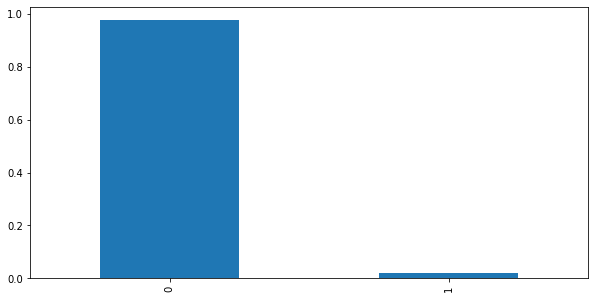

In [0]:
#check distribution of dependent variable
print(df.gb.value_counts(normalize=True))
df.gb.value_counts(normalize=True).plot(kind='bar')
plt.show()

**Conclusion:** 

Dataset target variable distribution is imbalanced. Our main metrics for classifiers will be F1-Score/ROC-AUC/Average precision score. We always should look also at confusion matrix, as it's sometimes a matter of tradeoff between various kinds of error rates. 

Other ideas:

- Logistic regression with weights;
- Undersampling/oversampling procedures;
- Balanced XGBoost
- Ensemble.

We will check on multicollinearity with condition number, as out matrix is too huge to do heatmap:


In [0]:
np.linalg.cond(X)

5.237360551072806e+43

Condition number is huge, which means that data is highly correlated, which not a surprise, given its relative sparcity and feature dimensionality.

#### **3. Baseline model - Logistic regression**

It is often used in scoring tasks, given its interpretability:

We will do our cross-validation mainly on training set and use our holdout set only for the final test before plotting confusion matrix and deciding on our final model.

In [0]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state=42, test_size=0.1)

Creating function to show test results and confusion matrix:

In [0]:
def show_results(model,numpy_arr=False):
  '''
  numpy_arr - whether we are using numpy array or raw Dataframe as our holdout set 
  (this needs to be established for our pipeline with over/undersampling method)
  '''
  if numpy_arr==True:
    pred_prob = model.predict_proba(X_holdout.values)[:,1]
    pred_val = model.predict(X_holdout.values) 
  else: 
    pred_prob = model.predict_proba(X_holdout)[:,1]
    pred_val = model.predict(X_holdout)
  print('Roc_AUC:',roc_auc_score(y_holdout, pred_prob))
  print('F1_Score:',f1_score(y_holdout, pred_val))
  print('Recall:',recall_score(y_holdout, pred_val,average='weighted'))
  print('Average precision score:',average_precision_score(y_holdout, pred_prob))
  #Confusion matrix
  plot_confusion_matrix(y_holdout, pred_val, normalize=True)
  plt.show()

In [0]:
logreg_base = LogisticRegression(random_state=42,solver='lbfgs')
model = logreg_base.fit(X_train, y_train)

Roc_AUC: 0.5538776095846187
F1_Score: 0.02030456852791878
Recall: 0.9280655982109579
Average precision score: 0.02172272064148509


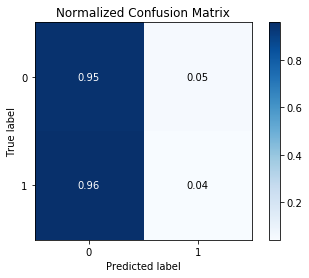

In [0]:
show_results(model)

**Conclusion:**

It seems like we are wrong practically every time on prediction of positive value. That's undertandable, given above-plotted distribution on target values.

#### **4. Logistic Regression with weights and data transformation:**

#####Data transformation :

- Scaling numerical features (can help with convergence and interpretation);

- Applying Weight of evidence transformation to categorical features (it is used vastly in practice exactly with LogReg).




In [0]:
#weight of evidence transformation
woe = category_encoders.woe.WOEEncoder(random_state=42,cols=cat_cols)

#scaling
scaler = StandardScaler()

#creating transformers for pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', scaler)])

categorical_transformer = Pipeline(steps=[
  ('woe', woe)
  ])

preprocessor = ColumnTransformer(
    transformers=[         
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])#,remainder='passthrough')


Defining metrics to use in cross-validation:

In [0]:
scoring = {'roc_auc' : make_scorer(roc_auc_score),  
           'f1_score' : make_scorer(f1_score),
           'average_precision_recall':make_scorer(average_precision_score)
           }

We will use 1:90 balance in weights, given our ratio in real data.Let's create pipeline which includes our transformation and classifier. 

In [0]:
logreg = LogisticRegression(random_state=42,solver='lbfgs',class_weight={0:1,1:90})
clf_lr = Pipeline(steps=[
                 ('preprocessor', preprocessor),
                 ('classifier', logreg)
                 ])

It will be used to every training fold in cross-validation loop:


In [0]:
scores = cross_validate(clf_lr, X_train, y_train, cv=10,scoring=scoring,n_jobs=-1)
print('Mean cross-val Roc_AUC:',np.mean(scores['test_roc_auc']))
print('Mean cross-val F1-score:',np.mean(scores['test_f1_score']))
print('Mean cross-val average_precision_recall:',np.mean(scores['test_average_precision_recall']))

Mean cross-val Roc_AUC: 0.8976480189297045
Mean cross-val F1-score: 0.358305610856262
Mean cross-val average_precision_recall: 0.19883226668786155


Our metrics are much better now! Let's see final results for our holdout set after using all training set:

Roc_AUC: 0.9752421264079203
F1_Score: 0.35114503816793896
Recall: 0.9366380916884085
Average precision score: 0.5751169364381603


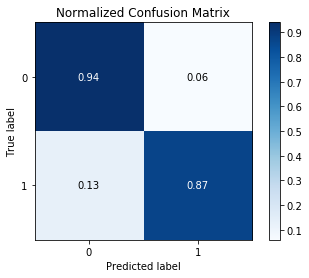

In [0]:
model = clf_lr.fit(X_train, y_train)
show_results(model)

We are doing a lot better now. Our true positive rate now is 87% versus 4% of baseline model. Let's try further improve model by combination of over/undersampling.

### Combination of over/undersampling - SMOTEEN

Over/under-sampling techniques are often used in order to solve imbalanced target variable problem. We will try to improve our above model with combination of those,called SMOTEEN.

But because SMOTEEN is a first step of our pipeline and returns only numpy array, we now need to rebuild our pipeline, so that our following data transformations in pipeline refer to column indexes instead of column strings. 

In [0]:
#extract indexes of categoricals and numericals
idx_num = np.where(X.columns.map(lambda x: x.startswith('num')))[0]
idx_cat = np.where(X.columns.map(lambda x: x.startswith('cat')))[0]

#woe with indexes instead of strings
woe = category_encoders.woe.WOEEncoder(random_state=42,cols=idx_cat)

#standard scaler with indexes instead of strings
preprocessor = ColumnTransformer(
    transformers=[                   
        ('num', StandardScaler(), idx_num)
        ], remainder='passthrough')

We will add SMOTEEN method to our pipeline using 'Pipeline' object from imblearn. We will also change (reduce) our class weight on positive class from 1:90 to at least 1:20 (but still not to 'balanced' as method works somewhat 'artificially' in vector space) after using SMOTEEN method.

In [0]:
smoteen_pipe = imb_Pipeline([
     ('smo', SMOTEENN(random_state=42)),
     ('woe', woe),
     ('pre', preprocessor),
     ('lr', LogisticRegression(random_state=42,solver='lbfgs',class_weight={0:1,1:20}) ),

 ])

Let's make a cross-validation:

In [0]:
scores = cross_validate(smoteen_pipe, X_train.values, y_train.values, cv=5,scoring=scoring,n_jobs=-1)
print('Mean cross-val Roc_AUC:',np.mean(scores['test_roc_auc']))
print('Mean cross-val F1-score:',np.mean(scores['test_f1_score']))
print('Mean cross-val average_precision_recall:',np.mean(scores['test_average_precision_recall']))

Mean cross-val Roc_AUC: 0.8979721733893771
Mean cross-val F1-score: 0.5038940011660704
Mean cross-val average_precision_recall: 0.3044694302755473


We see that our F1-score and average-precision recall results are significantly improved.

Let's test model on our holdout set:

Roc_AUC: 0.9844106463878328
F1_Score: 0.5222222222222223
Recall: 0.967946328736489
Average precision score: 0.6829350587451093


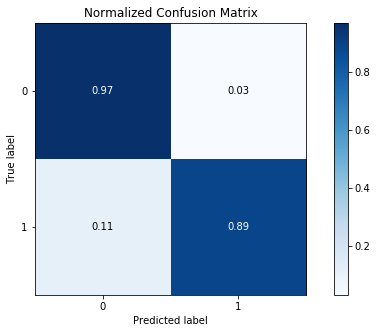

In [0]:
model_smo = smoteen_pipe.fit(X_train.values, y_train.values)
#check model on holdout
show_results(model_smo,numpy_arr=True)

We have improved our true positive and true negative rate with just randomly trying SMOTEEN. 

Let's see feature importances by considering magnitude of feature coefficient times the standard deviation of the corresponding parameter in the data. Note that we have multicorrelated data, so this results don't seem to be very reliable.

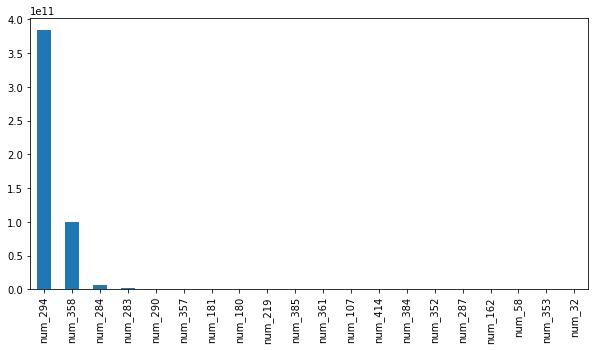

In [0]:
pd.Series(np.std(X_train, 0)*model_smo.named_steps['lr'].coef_[0]).sort_values(ascending=False)[:20].plot(kind='bar')
plt.show()

We won't use Grid-Search as this will take days to finish with SMOTEEN.

### Grid-search XGBoost params for imbalanced data:

We will use also XGBoost classifier with correction of balance between positive and negative classes, using 'scale pos_weight' argument. 

We won't use Standard Scaler in prepcoessing pipeline as this technique generally doesn't help in tree-based methods.

Let's go straight ahead for Grid Search for few XGBoost params,such as 'scale pos_weight','colsample_bytree', 'max_depth':

In [0]:
grid = {'classifier__scale_pos_weight': [20, 30, 40],
        'classifier__max_depth':[3,6,10],
        'classifier__colsample_bytree':[0.3,0.6,0.7]
        } 


xgb = XGBClassifier(n_estimators=150)
clf_xgb = Pipeline(steps=[
                 ('woe', woe), 
                 ('classifier', xgb)
                 ]
         )

precision_recall_auc = make_scorer(average_precision_score)

xgb_cv=GridSearchCV(clf_xgb,grid,cv=3,scoring=precision_recall_auc,n_jobs=-1)
xgb_cv.fit(X_train.values, y_train.values)
print(xgb_cv.best_params_)
print(xgb_cv.best_score_)

{'classifier__colsample_bytree': 0.3, 'classifier__max_depth': 6, 'classifier__scale_pos_weight': 40}
0.799459568417502


Let's retrain our model on best found tuned hyperparams:

Roc_AUC: 0.9951000789152737
F1_Score: 0.9433962264150944
Recall: 0.9977636973537085
Average precision score: 0.9623700714043387


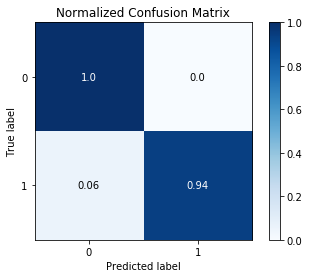

In [0]:
xgb = XGBClassifier(n_estimators=150, colsample_bytree=0.3, scale_pos_weight=40, max_depth=6)
clf_xgb = Pipeline(steps=[
                 ('woe', woe), 
                 ('classifier', xgb)
                 ]
         )
model_xgb = clf_xgb.fit(X_train.values, y_train.values)
#check model on holdout
show_results(model_xgb,numpy_arr=True)

We improved our model a lot. Let's plot named feature importances from this XGBoost model:

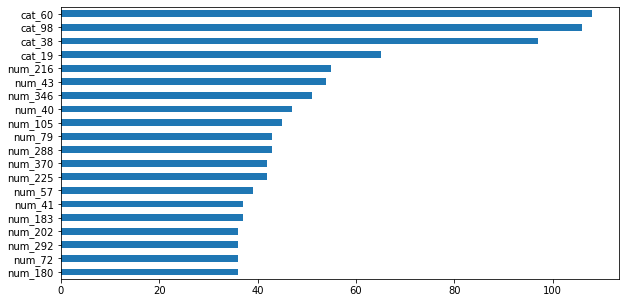

In [0]:
from operator import itemgetter
xgb_scores=model_xgb.named_steps['classifier'].get_booster().get_fscore()
sort_xgb_scores = sorted(xgb_scores.items(), key=itemgetter(1),reverse=True)
idx_top_20_features = [int(pair[0]) for pair in sort_xgb_scores[:20]]
top_20_vals = [pair[1] for pair in sort_xgb_scores[:20]]
x = list(reversed(X_train.columns[idx_top_features].tolist()))
y = list(reversed(top_20_vals))
pd.Series(data=y,index=x).plot(kind='barh')
plt.show()

Seems like 3 categorical features are the most important for our model.

Let's try using stacking ensemble:

### Stacking ensemble:

In [0]:
from vecstack import stacking

In [0]:
models = [
   smoteen_pipe,clf_xgb
]

S_train, S_test = stacking(models,                                                   # list of models
                           X_train.values, y_train.values, X_holdout.values,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and vote
                           needs_proba=False,          # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric=average_precision_score,      # metric: callable
                           n_folds=5,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=2)   


Roc_AUC: 0.9701413300810675
F1_Score: 0.9333333333333333
Recall: 0.9973909802459933
Average precision score: 0.8801049449754625


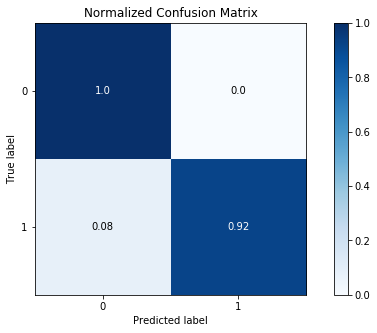

In [0]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize 2nd level model
model_nn = KNeighborsClassifier(n_neighbors=5)

# Fit 2nd level model
model_nn = model_nn.fit(S_train, y_train)

#show_results(model_nn)
pred_prob = model_nn.predict_proba(S_test)[:,1]
pred_val = model_nn.predict(S_test)
print('Roc_AUC:',roc_auc_score(y_holdout, pred_prob))
print('F1_Score:',f1_score(y_holdout, pred_val))
print('Recall:',recall_score(y_holdout, pred_val,average='weighted'))
print('Average precision score:',average_precision_score(y_holdout, pred_prob))
#Confusion matrix
plot_confusion_matrix(y_holdout, pred_val, normalize=True)
plt.show()

**Final conclusion:**

It seems that stacking model doesn't work as well as tuned XGBoost classifier (SMOTEEN pipeline decreases our results) and needs some improvement. Hence, we will use single XGBoost model on our final prediction.

**Final prediction:**

In [0]:
final_test = pd.read_csv('delay_df.csv',sep='\t')
final_test.drop('Unnamed: 0',axis=1,inplace=True)
#delete features with one value in train set
final_test.drop(unit_features,axis=1,inplace=True)
#delete id feature, as it doesn't provide us useful information for modelling (actually can casue data leakage)
final_test.drop('id',axis=1,inplace=True)
#deleting 80% of features, based on mask, computed earlier
final_test = final_test[cols[:-1]]
#imputing zeros instead of nans
final_test.fillna(0,axis=1,inplace=True)

In [0]:
pred_prob = model_xgb.predict_proba(final_test.values)[:,1]

Fetching csv-file results:

In [0]:
pd.DataFrame(data=pred_prob).rename(columns={0:'pred_prob'}).to_csv('pred_prob.csv')
files.download('pred_prob.csv') 

### **Possible improvement for future**:

- we didn't try a bunch of algorithms (tree-bases, MLP, One-Class SVM);

- we can further improve model by dealing with multicollinearity, especially for logistic regression: use few sfeature selection tchniques, including Lasso);

- we can further do some hyperparameter search, using other techniques;

- we can approach NaN values imputation in different mode, trying one-hot encoding;

- we can transform data using other transformation techniques, like frequency encoding, binning etc.